# Predicting Project Outcomes
## Introduction
The downgrading of projects at the closing from moderately satisfactory to moderately unsatisfactory has been a persistent problem in the World Bank and a particular problem in the World Bank's East Asia and Pacific region since 2012. Through analysis of the projects that exited the East Asia and Pacific region's portfolio in fiscal years 2012 and 2013, this paper derives a prediction model based on ratings for implementation progress and achievement of development objectives during project supervision. The model, used in combination with other indicators of project progress toward outcomes, appears to improve on existing methods for assessing the downgrade risk.

## Objective
Our objective here is to build a binary classifier to predict the probability whether a project will be “closed” or “canceled/distressed”

## Environment Setup

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
# Load data.The dataset includes basic information such as the project title, task manager, country, project id, sector, themes, commitment amount, product line, and financing. It also provides links to publicly disclosed online documents.
data = pd.read_excel('World_Bank_Projects.xls')
data.dataframeName = 'projects-operations-csv-.csv'

## Data Exploration

In [3]:
pd.options.display.max_columns = None
data.head()

,id,regionname,countryname,projectstatusdisplay,project_name,pdo,impagency,cons_serv_reqd_ind,url,boardapprovaldate,closingdate,projectfinancialtype,curr_project_cost,curr_ibrd_commitment,curr_ida_commitment,curr_total_commitment,grantamt,borrower,lendinginstr,envassesmentcategorycode,esrc_ovrl_risk_rate,sector1,sector2,sector3,theme1,theme2
0,P174708,Middle East and North Africa,West Bank and Gaza,Active,Phase 2 Advancing Sustainability in Performanc...,To improve operational and financial performan...,Palestinian Energy and Natural Resources Autho...,NaN,http://projects.worldbank.org/P174708/null?lan...,2022-03-21T00:00:00Z,NaN,Other;Grants,23500000.0,0,0,0,15000000,Ministry of Finance,Investment Project Financing,B,Substantial,NaN,NaN,NaN,NaN,NaN
1,P176877,Latin America and Caribbean,Federative Republic of Brazil,Active,Governance Risk Assessment System Brazil Scale-Up,Improve the process of detecting fraud in publ...,National Council for Internal Control - CONACI,NaN,http://projects.worldbank.org/P176877/null?lan...,2022-03-21T00:00:00Z,NaN,Grants,130000.0,0,0,0,130000,National Council for Internal Control - CONACI,Investment Project Financing,NaN,Low,NaN,NaN,NaN,NaN,NaN
2,P160865,Africa West,Federal Republic of Nigeria,Active,Livestock Productivity and Resilience Support ...,"To improve productivity, commercialization, an...",Federal Ministry of Agriculture and Rural Deve...,Y,http://projects.worldbank.org/P160865/null?lan...,2022-03-18T00:00:00Z,NaN,IDA,500000000.0,0,500000000,500000000,0,Federal Republic of Nigeria,Investment Project Financing,B,NaN,NaN,NaN,NaN,NaN,NaN
3,P170113,Europe and Central Asia,Republic of Kosovo,Active,Kosovo Public Finances and Sustainable Growth ...,The objective of the proposed Public Finances ...,"Ministry of Finance, Labor and Transfers",NaN,http://projects.worldbank.org/P170113/null?lan...,2022-03-18T00:00:00Z,2023-09-30T00:00:00Z,IDA,56400000.0,0,56400000,56400000,0,Republic of Kosovo,Development Policy Lending,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P172922,Africa East,United Republic of Tanzania,Active,Additional Financing to the Citizen-Centric Ju...,The project development objective is to improv...,Judiciary of Tanzania,NaN,http://projects.worldbank.org/P172922/null?lan...,2022-03-18T00:00:00Z,NaN,IDA,90000000.0,0,90000000,90000000,0,United Republic of Tanzania,Investment Project Financing,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21474 entries, 0 to 21473
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        21474 non-null  object 
 1   regionname                21472 non-null  object 
 2   countryname               21472 non-null  object 
 3   projectstatusdisplay      21472 non-null  object 
 4   project_name              21474 non-null  object 
 5   pdo                       11508 non-null  object 
 6   impagency                 6535 non-null   object 
 7   cons_serv_reqd_ind        1436 non-null   object 
 8   url                       21474 non-null  object 
 9   boardapprovaldate         18600 non-null  object 
 10  closingdate               16452 non-null  object 
 11  projectfinancialtype      12861 non-null  object 
 12  curr_project_cost         21327 non-null  float64
 13  curr_ibrd_commitment      21474 non-null  int64  
 14  curr_i

In [5]:
# get a list of columns that have more than 50% null values
na_values = data.isnull().mean()
na_values[na_values>0.5]

impagency              0.695678
cons_serv_reqd_ind     0.933128
borrower               0.706482
esrc_ovrl_risk_rate    0.944258
sector3                0.651346
theme2                 0.539210
dtype: float64

In [6]:
# drop columns with more than 50% null values
data.dropna(thresh = data.shape[0]*0.5, how = 'all', axis = 1, inplace = True)

In [7]:
# Re-explore the df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21474 entries, 0 to 21473
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        21474 non-null  object 
 1   regionname                21472 non-null  object 
 2   countryname               21472 non-null  object 
 3   projectstatusdisplay      21472 non-null  object 
 4   project_name              21474 non-null  object 
 5   pdo                       11508 non-null  object 
 6   url                       21474 non-null  object 
 7   boardapprovaldate         18600 non-null  object 
 8   closingdate               16452 non-null  object 
 9   projectfinancialtype      12861 non-null  object 
 10  curr_project_cost         21327 non-null  float64
 11  curr_ibrd_commitment      21474 non-null  int64  
 12  curr_ida_commitment       21474 non-null  int64  
 13  curr_total_commitment     21474 non-null  int64  
 14  granta

## Identify the target variable

In [8]:
# explore the unique values in loan_status column
data['projectstatusdisplay'].value_counts(normalize = True)

Closed      0.732023
Active      0.138273
Dropped     0.079452
Pipeline    0.050251
Name: projectstatusdisplay, dtype: float64

In [9]:
# create a new column based on the projectstatusdisplay column that will be our target variable
data['will_close'] = np.where(data.loc[:, 'projectstatusdisplay'].isin(['Closed','Dropped']), 1, 0)
# Drop the original 'projectstatusdisplay' column
data.drop(columns = ['projectstatusdisplay'], inplace = True)

'''
drop redundant and forward-looking columns
redundant like id, project_name, pdo, etc.
"closingdate" is a forward-looking columns so will drop it as well
'''
data.drop(columns = ['id', 'project_name', 'pdo', 'url', "closingdate"], inplace = True)

In [10]:
data['will_close'].value_counts(normalize = True)

1    0.8114
0    0.1886
Name: will_close, dtype: float64

## EDA

#### Line plot:

<AxesSubplot:>

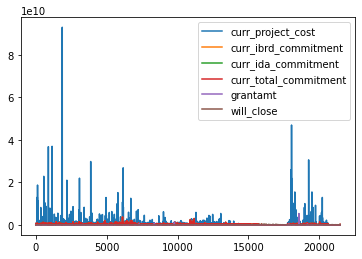

In [11]:

data.plot()

<AxesSubplot:xlabel='grantamt'>

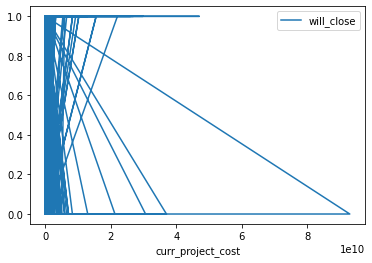

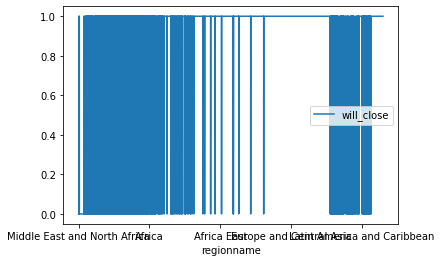

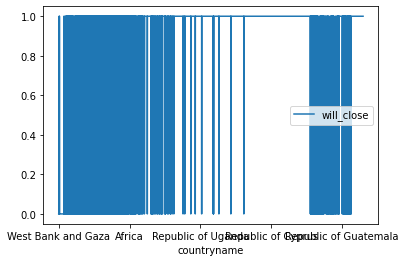

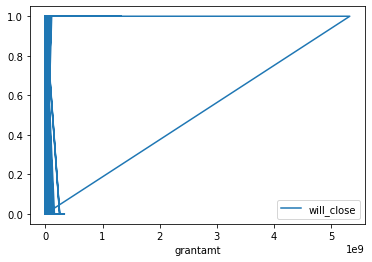

In [12]:
# plotting a line chart Of X(independent var) with y(dependent var)
data.plot(x="curr_project_cost", y="will_close")
data.plot(x="regionname", y="will_close")
data.plot(x="countryname", y="will_close")
data.plot(x="grantamt", y="will_close")

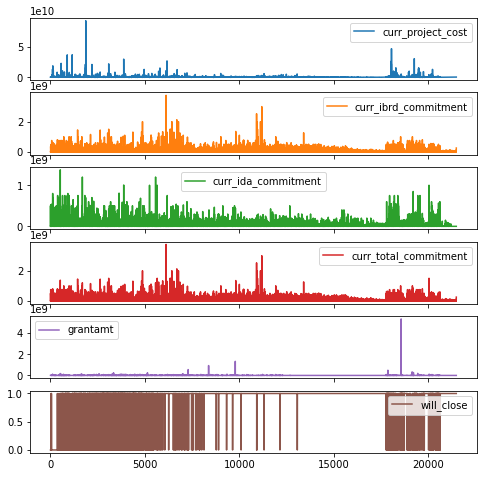

In [13]:
data.plot(subplots=True, figsize=(8, 8));

## General data cleaning

### Need to Figure out percentage of missing data in each column
Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a Stack Overflow Forum Missing Values

In [14]:
# Function to calculate missing values by column
def detect_outliers(df,n,features):
    # import counter class from collections module
    from collections import Counter
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers
def missing_values_table(df):
    
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 15 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
sector2,10432,48.6
theme1,9219,42.9
projectfinancialtype,8613,40.1
envassesmentcategorycode,8391,39.1
boardapprovaldate,2874,13.4
sector1,2002,9.3
lendinginstr,248,1.2
curr_project_cost,147,0.7
regionname,2,0.0
countryname,2,0.0


In [15]:
# dropping all the columns with excess Nan values
data.drop(columns = ["sector2", "theme1", "projectfinancialtype", "envassesmentcategorycode"], inplace = True)

## Missing Values

In [16]:
data.dropna(axis = 0,inplace = True)

In [17]:
data.shape

(18112, 11)

In [18]:
data.isna().sum()

regionname               0
countryname              0
boardapprovaldate        0
curr_project_cost        0
curr_ibrd_commitment     0
curr_ida_commitment      0
curr_total_commitment    0
grantamt                 0
lendinginstr             0
sector1                  0
will_close               0
dtype: int64

## date columns

In [19]:
import datetime

# convert date columns to datetime format and create a new column as a difference between today and the respective date
def convert_date(val):
    try:
        y,m,d = val.split('-')
        d = d[:2]
    except AttributeError:
        return pd.NaT
    return datetime.datetime(int(y),int(m),int(d))
data.boardapprovaldate = data.boardapprovaldate.map(convert_date)
# for i in df['boardapprovaldate']:
#     df[column] = datetime.datetime.fromisoformat(str(df[column])[:-1]).astimezone(timezone.utc)
def date_columns(df, column):

    # store current month
    today_date = pd.to_datetime('2022-03-25')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%Y-%m-%d")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
    
# apply to data
date_columns(data, 'boardapprovaldate')


In [20]:
data['mths_since_boardapprovaldate'].head()

33    1.0
39    1.0
56    1.0
63    2.0
69    2.0
Name: mths_since_boardapprovaldate, dtype: float64

## Split data

In [21]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = data.drop('will_close', axis = 1)
y = data['will_close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# specifically hard copying the training sets to avoid Pandas' SetttingWithCopyWarning when we play around with this data later on.
# as noted [here](https://github.com/scikit-learn/scikit-learn/issues/8723), this is currently an open issue between Pandas and Scikit-Learn teams
X_train, X_test = X_train.copy(), X_test.copy()

In [22]:
X_train.shape, X_test.shape

((14489, 10), (3623, 10))

# Feature selection

In [23]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [24]:
X_train_cat.columns

Index(['regionname', 'countryname', 'lendinginstr', 'sector1'], dtype='object')

### Chi-squared statistic for categorical features

In [25]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,regionname,0.0
1,countryname,0.0
2,lendinginstr,0.0
3,sector1,0.0


Let's keep four categorical features because they have a good p-score

### ANOVA F-Statistic for numerical features

In [26]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,mths_since_boardapprovaldate,4688.891109,0.000000
1,curr_ida_commitment,673.358734,0.000000
2,curr_total_commitment,153.985571,0.000000
3,curr_project_cost,48.691630,0.000000
4,grantamt,10.860989,0.000984
5,curr_ibrd_commitment,0.028527,0.865879


For the sake of simplicity, and low number of variable we will keep the features and calculate pair-wise correlations between them

### Pair wise correlations to detect multicollinearity

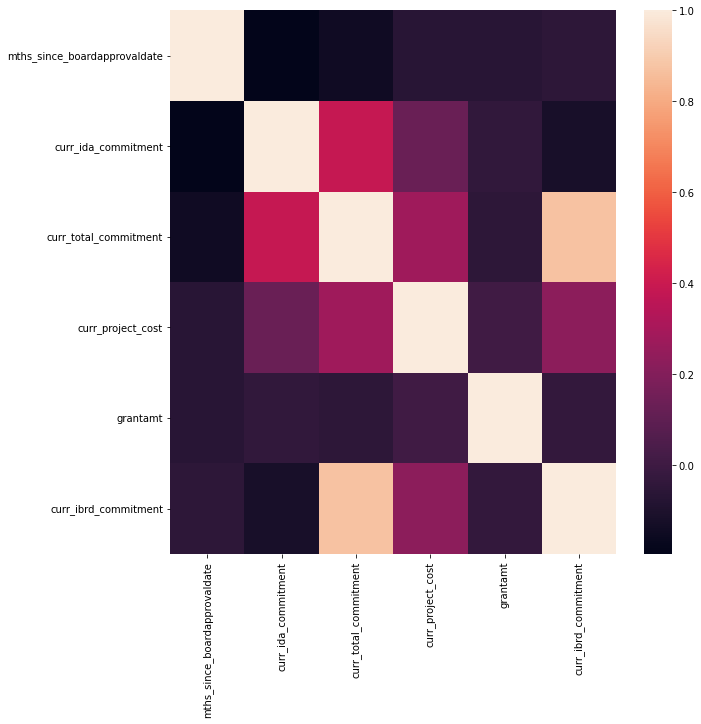

In [27]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[0:,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat);

since not a single feature have multicollinearity with other features, we don't have to drop any

## Outliers Treatment

In [28]:
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(X_train,2,["curr_ibrd_commitment",            
                                            "curr_ida_commitment" ,         
                                            "curr_total_commitment" ,      
                                            "grantamt",])

In [29]:
X_train = X_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [30]:
y_train = y_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [31]:
X_train.shape

(14437, 10)

## Creating dummy variables / Label encoding
### Convet discrete variables (with less uniques values) to dummy variables and Label encoding the variables (with large numbers of unique values)

In [32]:
object_col = X_train.select_dtypes(include = "object")
object_col.columns

Index(['regionname', 'countryname', 'lendinginstr', 'sector1'], dtype='object')

In [33]:
# function to print number of uniques in input column
def unique_printer(data, col_list):
    for col in col_list:
        print(f'"{col}" have {len(data[col].unique())} uniques')
unique_printer(data, object_col)

"regionname" have 9 uniques
"countryname" have 204 uniques
"lendinginstr" have 18 uniques
"sector1" have 144 uniques


In [34]:
X_train['countryname'].value_counts(normalize = True)

Republic of India                           0.038720
Republic of Indonesia                       0.030339
People's Republic of China                  0.029508
Federative Republic of Brazil               0.026598
Islamic Republic of Pakistan                0.021680
                                              ...   
Socialist People's Libyan Arab Jamahiriy    0.000069
French Republic                             0.000069
Antigua and Barbuda                         0.000069
Grand Duchy of Luxembourg                   0.000069
Mercosur                                    0.000069
Name: countryname, Length: 203, dtype: float64

In [35]:
X_train['sector1'].value_counts(normalize = True)

Central Government (Central Agencies)      0.097112
Health                                     0.049248
Social Protection                          0.048417
Irrigation and Drainage                    0.032832
Other Agriculture, Fishing and Forestry    0.029715
                                             ...   
(Historic)Agro-industry                    0.000069
(Historic)Business environment             0.000069
(Historic)Environmental institutions       0.000069
Petrochemicals and fertilizers             0.000069
(Historic)Macro/non-trade                  0.000069
Name: sector1, Length: 142, dtype: float64

In [36]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    df.drop(columns = columns_list, inplace = True)
    return df

# creating dummys of varibales that have less uniques
X_train = dummy_creation(X_train, ['regionname', 'lendinginstr'])
X_test = dummy_creation(X_test, ['regionname', 'lendinginstr'])

# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column that have large number of  unique values
X_train['countryname']= label_encoder.fit_transform(X_train['countryname'])
X_train['sector1']= label_encoder.fit_transform(X_train['sector1'])

X_test['countryname']= label_encoder.fit_transform(X_test['countryname'])
X_test['sector1']= label_encoder.fit_transform(X_test['sector1'])
 
X_train['countryname'].unique()

array([ 87, 166, 119, 192, 143,  91, 106, 199, 120, 123,  33, 195, 164,
        41, 197,  80, 131, 179,  30,   5, 172,   3,  81, 132,  66,  14,
        56, 147, 136,  31, 198,  94,  59, 148, 200,  46,  62, 159, 126,
       116,  49,  99,  10, 100,  36, 137, 157,  64, 102,  24, 112, 161,
       101,   9,  39, 103, 173,  90, 139, 160, 128, 177,   7, 149,  28,
        43,  74, 165, 162, 168,  26,  71, 117, 196, 138,  25, 156, 169,
       144,  67, 146, 125,  83, 133, 170,  11, 185, 105,  85, 194,  38,
       145,  60,  95,  48,  51,  55,  97,  18,  45,  65, 142,  92,  96,
        98,  17,  86, 141,  52,   0,  19,  63, 130, 122,  44, 175, 174,
       107, 191,  79, 187, 167, 171, 190, 155, 135, 134, 202, 153, 108,
       124,  70,  22, 127,  82,  76,  15, 163, 180,  89,  77, 111, 158,
       104,  40,   8,  58, 121, 129,  84, 114, 113, 184,  21, 110, 181,
        75,  42,  72,  47,  54, 176, 152, 201,  23,  32,  93, 182, 140,
        35, 118,  61,  37,  78, 183, 115, 188, 150,  13,  53,  2

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623 entries, 7876 to 6477
Data columns (total 35 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   countryname                                           3623 non-null   int32  
 1   curr_project_cost                                     3623 non-null   float64
 2   curr_ibrd_commitment                                  3623 non-null   int64  
 3   curr_ida_commitment                                   3623 non-null   int64  
 4   curr_total_commitment                                 3623 non-null   int64  
 5   grantamt                                              3623 non-null   int64  
 6   sector1                                               3623 non-null   int32  
 7   mths_since_boardapprovaldate                          3623 non-null   float64
 8   regionname:Africa                                     3

# Model

In [38]:
# define modeling pipeline
df_clf = make_pipeline(StandardScaler(),
                    DecisionTreeClassifier())
rf_clf = make_pipeline(StandardScaler(),
                    RandomForestClassifier())
sgd_clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
lr = make_pipeline(StandardScaler(),
                    LogisticRegression(solver='lbfgs', max_iter=100))
gnb = make_pipeline(StandardScaler(),
                    GaussianNB())
# fitting the SGDClassifier pipeline and predicting on test dataset
sgd_clf.fit(X_train, y_train)
print(sgd_clf.score(X_test, y_test))
# fitting the LogisticRegression pipeline and predicting on test dataset
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
# fitting the GaussianNB pipeline and predicting on test dataset
gnb.fit(X_train, y_train)
print(gnb.score(X_test, y_test))
# fitting the DecisionTreeClassifier pipeline and predicting on test dataset
df_clf.fit(X_train, y_train)
print(df_clf.score(X_test, y_test))
# fitting the RandomForestClassifier pipeline and predicting on test dataset
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.9359646701628485


C:\Users\aimlteam2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9472812586254485
0.6340049682583494
0.934032569693624
0.9585978470880486


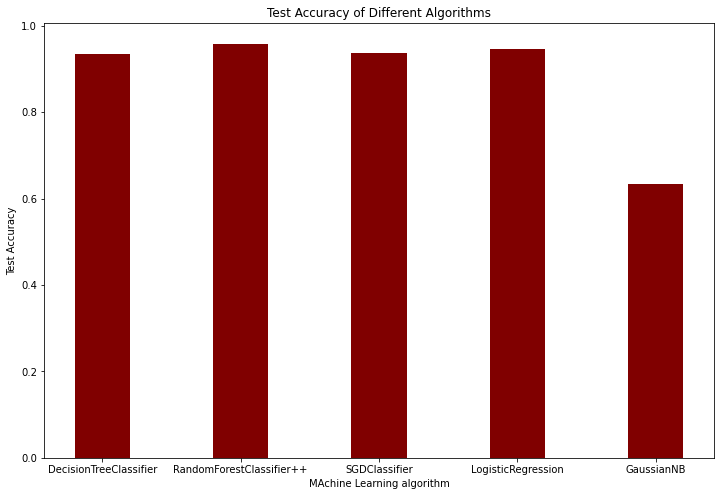

In [56]:
# creating the dataset
data = {'DecisionTreeClassifier':df_clf.score(X_test, y_test), 'RandomForestClassifier++':rf_clf.score(X_test, y_test), 'SGDClassifier':sgd_clf.score(X_test, y_test),
        'LogisticRegression':lr.score(X_test, y_test), 'GaussianNB':gnb.score(X_test, y_test)}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("MAchine Learning algorithm")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of Different Algorithms")
plt.show()
fig.savefig('test.png')

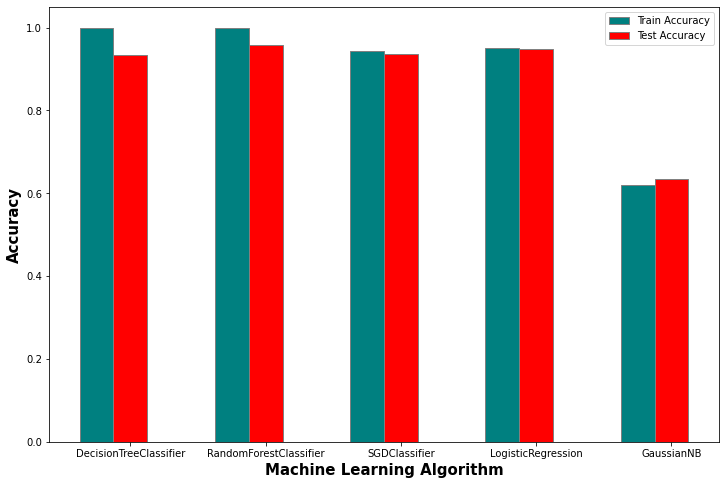

In [69]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Train_Accuracy = [df_clf.score(X_train, y_train), rf_clf.score(X_train, y_train), sgd_clf.score(X_train, y_train), lr.score(X_train, y_train), gnb.score(X_train, y_train)]
Test_Accuracy = [df_clf.score(X_test, y_test),rf_clf.score(X_test, y_test), sgd_clf.score(X_test, y_test), lr.score(X_test, y_test), gnb.score(X_test, y_test)]
 
# Set position of bar on X axis
br1 = np.arange(len(Train_Accuracy))
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, Train_Accuracy, color ='teal', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, Test_Accuracy, color ='red', width = barWidth,
        edgecolor ='grey', label ='Test Accuracy')

# Adding Xticks
plt.xlabel('Machine Learning Algorithm', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Train_Accuracy))],
        ['DecisionTreeClassifier', 'RandomForestClassifier', 'SGDClassifier', 'LogisticRegression', 'GaussianNB'])
plt.savefig("{}train_test.png", format='png')
plt.legend()
plt.show()


In [67]:
fig1

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Machine Learning Algorithm', ylabel='Accuracy'>)